In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['ddataset', 'aptos2019-blindness-detection', 'weights']


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy, categorical_crossentropy
#from keras.applications.resnet50 import preprocess_input
from keras.applications.densenet import DenseNet121,DenseNet169
from keras.applications import densenet
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score, cohen_kappa_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import imgaug as ia

WORKERS = 2
CHANNEL = 3
import warnings
warnings.filterwarnings("ignore")
SIZE = 256
NUM_CLASSES = 5

In [4]:
df_train = pd.read_csv('../input/ddataset/dataset/dataset/new_image_label.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [5]:
df_train['id_code'] = df_train['id_code'].map(lambda x: str(x)[:-4])

In [6]:
df_train['diagnosis'].value_counts()

0    1422
1    1147
2     811
3     609
4     501
Name: diagnosis, dtype: int64

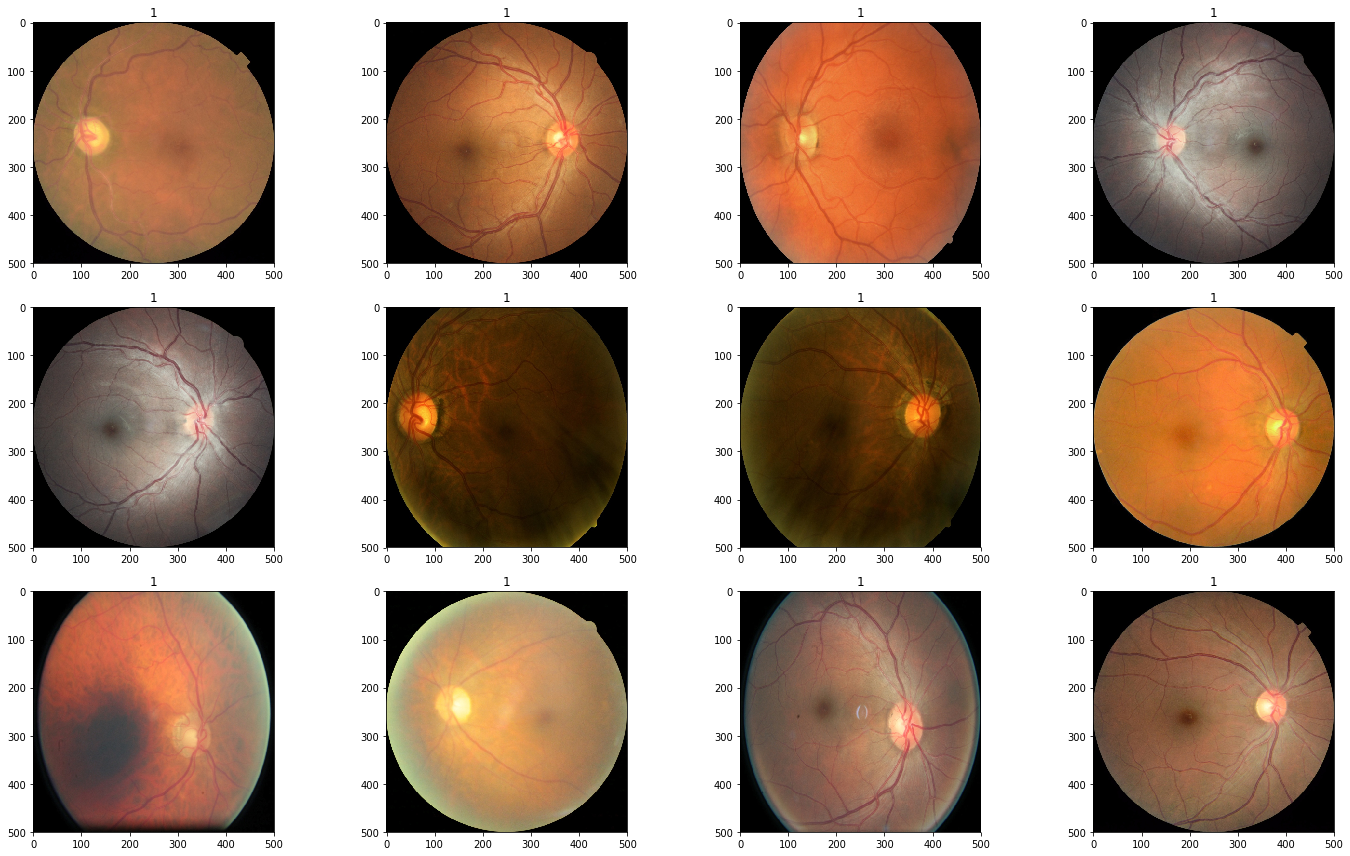

In [7]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/ddataset/dataset/dataset/new image/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(df_train)

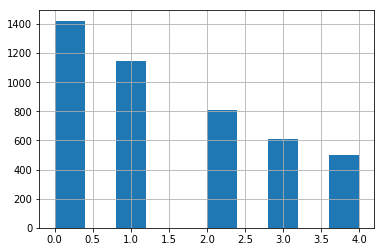

In [8]:
x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=23)
y.hist()

In [9]:
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.20,
                                                      stratify=y, random_state=8)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(3592,)
(3592, 5)
(898,)
(898, 5)


In [10]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True)

In [11]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels,
                 batch_size, is_train=True,
                 mix=False, augment=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size
        self.is_train = is_train
        self.is_augment = augment
        if(self.is_train):
            self.on_epoch_end()
        self.is_mix = mix

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        if(self.is_train):
            return self.train_generate(batch_x, batch_y)
        return self.valid_generate(batch_x, batch_y)

    def on_epoch_end(self):
        if(self.is_train):
            self.image_filenames, self.labels = shuffle(self.image_filenames, self.labels)
        else:
            pass
    
    def mix_up(self, x, y):
        lam = np.random.beta(0.2, 0.4)
        ori_index = np.arange(int(len(x)))
        index_array = np.arange(int(len(x)))
        np.random.shuffle(index_array)        
        
        mixed_x = lam * x[ori_index] + (1 - lam) * x[index_array]
        mixed_y = lam * y[ori_index] + (1 - lam) * y[index_array]
        
        return mixed_x, mixed_y

    def train_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/ddataset/dataset/dataset/new image/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            if(self.is_augment):
                img = seq.augment_image(img)
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        if(self.is_mix):
            batch_images, batch_y = self.mix_up(batch_images, batch_y)
        return batch_images, batch_y

    def valid_generate(self, batch_x, batch_y):
        batch_images = []
        for (sample, label) in zip(batch_x, batch_y):
            img = cv2.imread('../input/ddataset/dataset/dataset/new image/'+sample+'.png')
            img = cv2.resize(img, (SIZE, SIZE))
            batch_images.append(img)
        batch_images = np.array(batch_images, np.float32) / 255
        batch_y = np.array(batch_y, np.float32)
        return batch_images, batch_y

In [12]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None,include_top=False,input_tensor=input_tensor)
    base_model.load_weights('../input/weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.6)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output) 
    return model

In [13]:
from keras import backend as K
from keras.optimizers import Adam


def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
from keras import optimizers, applications

from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

epochs = 50; batch_size = 16
checkpoint = ModelCheckpoint('../working/densenet_1.h5', monitor='val_f1_m', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_f1_m', factor=0.5, patience=4,
                                   verbose=1, mode='max', epsilon=0.0001)
early = EarlyStopping(monitor="val_f1_m", 
                      mode="max", 
                      patience=7)

csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

train_generator = My_Generator(train_x, train_y, 128, is_train=True)
train_mixup = My_Generator(train_x, train_y, batch_size, is_train=True, mix=False, augment=True)
valid_generator = My_Generator(valid_x, valid_y, batch_size, is_train=False)

model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=NUM_CLASSES)

metric_list = ['accuracy',f1_m,precision_m, recall_m]

In [15]:
# reference link: https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow
def kappa_loss(y_true, y_pred, y_pow=2, eps=1e-12, N=5, bsize=32, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom*0.5 / (denom + eps) + categorical_crossentropy(y_true, y_pred)*0.5

In [16]:
from keras.callbacks import Callback
class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=False,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
            
            score = cohen_kappa_score(flatten(self.y_val),
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('saving checkpoint: ', score)
                self.model.save('../working/densenet_bestqwk_1.h5')

qwk = QWKEvaluation(validation_data=(valid_generator, valid_y),
                    batch_size=batch_size, interval=1)

In [17]:
#0    1422
#1    1147
#2     811
#3     609
#4     501
class_weights={0:0.8,1:0.83,2:0.91,3:1,4:1.05}

In [18]:
# warm up model
for layer in model.layers:
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3),metrics=metric_list
)

model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_y)) / float(128)),
    epochs=2,
    workers=WORKERS, use_multiprocessing=True,
    verbose=1,
    callbacks=[qwk],class_weight=class_weights)

Epoch 1/2
57/57 [==============================] - 17s 302ms/step

 epoch: 1 - QWK_score: 0.000000 

saving checkpoint:  0.0
Epoch 2/2
57/57 [==============================] - 15s 260ms/step

 epoch: 2 - QWK_score: 0.000000 

saving checkpoint:  0.0


In [19]:
# train all layers
for layer in model.layers:
    layer.trainable = True
    
    
callbacks_list = [checkpoint, csv_logger, reduceLROnPlat, early, qwk]
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(lr=1e-4),metrics=metric_list)
model.fit_generator(
    train_mixup,
    steps_per_epoch=np.ceil(float(len(train_x)) / float(batch_size)),
    validation_data=valid_generator,
    validation_steps=np.ceil(float(len(valid_x)) / float(batch_size)),
    epochs=epochs,
    verbose=1,
    workers=1, use_multiprocessing=False,
    callbacks=callbacks_list,class_weight=class_weights)

Epoch 1/50
225/225 [==============================] - 113s 504ms/step - loss: 1.2341 - acc: 0.3906 - f1_m: 0.2184 - precision_m: 0.5447 - recall_m: 0.1408 - val_loss: 1.2356 - val_acc: 0.4421 - val_f1_m: 0.3364 - val_precision_m: 0.5297 - val_recall_m: 0.2506

Epoch 00001: val_f1_m improved from -inf to 0.33636, saving model to ../working/densenet_1.h5
57/57 [==============================] - 9s 158ms/step

 epoch: 1 - QWK_score: 0.565319 

saving checkpoint:  0.5653185150652582
Epoch 2/50
225/225 [==============================] - 99s 441ms/step - loss: 1.1258 - acc: 0.4589 - f1_m: 0.3192 - precision_m: 0.6353 - recall_m: 0.2200 - val_loss: 1.1650 - val_acc: 0.4777 - val_f1_m: 0.2954 - val_precision_m: 0.6305 - val_recall_m: 0.1993

Epoch 00002: val_f1_m did not improve from 0.33636
57/57 [==============================] - 8s 144ms/step

 epoch: 2 - QWK_score: 0.643529 

saving checkpoint:  0.6435286263329785
Epoch 3/50
225/225 [==============================] - 96s 426ms/step - loss:


Epoch 00019: val_f1_m improved from 0.53534 to 0.55542, saving model to ../working/densenet_1.h5
57/57 [==============================] - 8s 142ms/step

 epoch: 19 - QWK_score: 0.758871 

Epoch 20/50
225/225 [==============================] - 99s 439ms/step - loss: 0.7650 - acc: 0.6353 - f1_m: 0.5980 - precision_m: 0.7456 - recall_m: 0.5044 - val_loss: 1.0544 - val_acc: 0.5601 - val_f1_m: 0.5515 - val_precision_m: 0.6093 - val_recall_m: 0.5067

Epoch 00020: val_f1_m did not improve from 0.55542
57/57 [==============================] - 8s 141ms/step

 epoch: 20 - QWK_score: 0.756423 

Epoch 21/50
225/225 [==============================] - 95s 423ms/step - loss: 0.7514 - acc: 0.6486 - f1_m: 0.6179 - precision_m: 0.7584 - recall_m: 0.5264 - val_loss: 1.0629 - val_acc: 0.5724 - val_f1_m: 0.5493 - val_precision_m: 0.6092 - val_recall_m: 0.5033

Epoch 00021: val_f1_m did not improve from 0.55542
57/57 [==============================] - 8s 140ms/step

 epoch: 21 - QWK_score: 0.777226 

savin

57/57 [==============================] - 8s 141ms/step

 epoch: 38 - QWK_score: 0.782946 

Epoch 39/50
225/225 [==============================] - 98s 435ms/step - loss: 0.5022 - acc: 0.7797 - f1_m: 0.7712 - precision_m: 0.8506 - recall_m: 0.7086 - val_loss: 1.2550 - val_acc: 0.5947 - val_f1_m: 0.5916 - val_precision_m: 0.6163 - val_recall_m: 0.5702

Epoch 00039: val_f1_m improved from 0.58691 to 0.59165, saving model to ../working/densenet_1.h5
57/57 [==============================] - 8s 142ms/step

 epoch: 39 - QWK_score: 0.784399 

Epoch 40/50
225/225 [==============================] - 98s 436ms/step - loss: 0.4857 - acc: 0.7792 - f1_m: 0.7733 - precision_m: 0.8423 - recall_m: 0.7186 - val_loss: 1.4031 - val_acc: 0.6047 - val_f1_m: 0.5971 - val_precision_m: 0.6201 - val_recall_m: 0.5768

Epoch 00040: val_f1_m improved from 0.59165 to 0.59709, saving model to ../working/densenet_1.h5
57/57 [==============================] - 8s 142ms/step

 epoch: 40 - QWK_score: 0.792140 

saving chec

In [20]:
submit = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
model.load_weights('../working/densenet_bestqwk_1.h5')
predicted = []

In [21]:
# reference:https://www.kaggle.com/CVxTz/cnn-starter-nasnet-mobile-0-9709-lb 
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
    image = cv2.imread(path)
    image = cv2.resize(image, (SIZE, SIZE))
    X = np.array((image[np.newaxis])/255)
    score_predict=((model.predict(X).ravel()*model.predict(X[:, ::-1, :, :]).ravel()*model.predict(X[:, ::-1, ::-1, :]).ravel()*model.predict(X[:, :, ::-1, :]).ravel())**0.25).tolist()
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))

1928it [02:30, 12.83it/s]


In [22]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [23]:
submit['diagnosis'].value_counts()

2    874
3    344
0    300
1    253
4    157
Name: diagnosis, dtype: int64

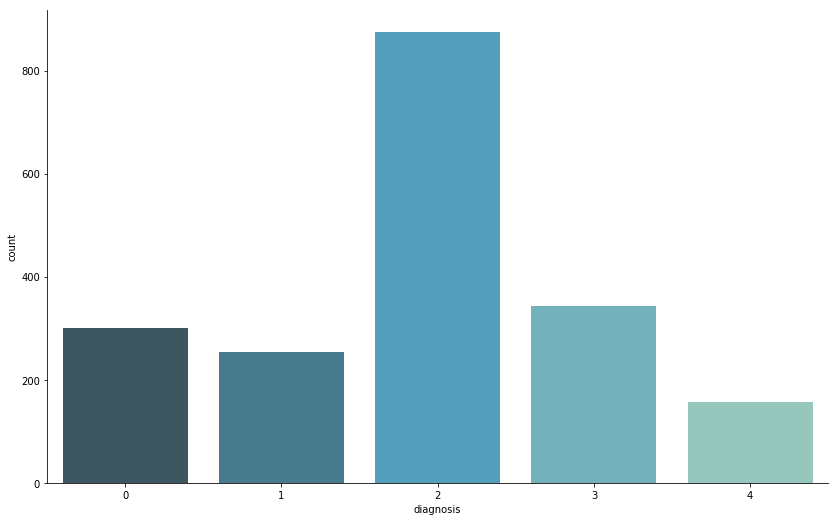

In [24]:
import seaborn as sns

f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=submit, palette="GnBu_d")
sns.despine()
plt.show()

# Steps:

1) The data is higly imbalance 

2) We resize the image size to 256*256

3) We use the training data to generate new images with a little alteration in the images - Data Augmentation

4) As the data is less and with low computational power, we will use pretrained weights - Resnet-50 to build model and add a layer to classify the data.

5) We use methods like Early stopping with validation F1-Score, ReduceLROnPlateau and modelcheckpoint to avoid overfitting of data

6) Evaluating the Quadratic Kappa score for each epoch.

7) We train the last 3 layers with two epochs as warmup.

8) Training the model with 50 epochs.

9) Prediction for test data using the model that is built. 

# The kappa score on test data is 0.608